# ASL Transforms - Sandbox

This notebook was used to test and experiment with our custom ASL transforms. It is not in a working state any longer.

In [15]:
%pip install -q kornia

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install opencv-python matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
# from hand_transform import *
import torchvision.transforms.v2 as transforms

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2
import torchvision.models as visionmodels

import torch.nn as nn

import lightning as L
import numpy as np
import cv2 as cv

from asl_transforms import ExtractHand, RandomBackgroundNoise, RandomRealLifeBackground

In [2]:
t = transforms.Compose(transforms=(
    transforms.Resize(size=(224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    ExtractHand(),
    transforms.RandomPerspective(),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.3),
    RandomBackgroundNoise(),
    # transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
))

In [3]:
# orig_img = Image.open(Path("/home/jovyan/Test-Hands/A") / 'A_1.jpeg')
orig_img = Image.open(Path(r"C:/Users/kybur/Desktop/") / '10.jpg')
bg = r"C:/Users/kybur/Desktop/2025-03-02 19_24_47-Total War_ WARHAMMER 3.png"

In [4]:
t_bg = transforms.Compose(transforms=(
    transforms.Resize(size=(224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    ExtractHand(),
    transforms.RandomPerspective(),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.3),
    RandomRealLifeBackground(backgrounds=[bg]),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
))

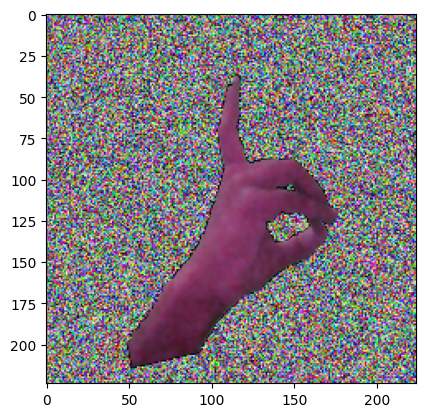

In [13]:
plt.imshow(t(orig_img)[0].permute(1, 2, 0))

(224, 224, 1)
(224, 224, 3)
(224, 224, 3) uint8


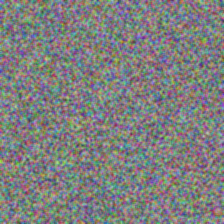

In [6]:
mask = np.zeros((224,224), dtype=np.uint8)
img = np.ones((224,224,3), dtype=np.uint8)

noise = np.random.uniform(0, 255, size=img.shape).astype(np.uint8)

mask = np.expand_dims(mask, -1)
print(mask.shape)
print((img * mask / 255).shape)

img_with_noise = np.astype(img * (mask / 255) + noise * ((255 - mask) / 255), np.uint8)

img_with_noise = cv.GaussianBlur(img_with_noise, (3, 3), 1.5)
print(img_with_noise.shape, img_with_noise.dtype)

Image.fromarray(img_with_noise)

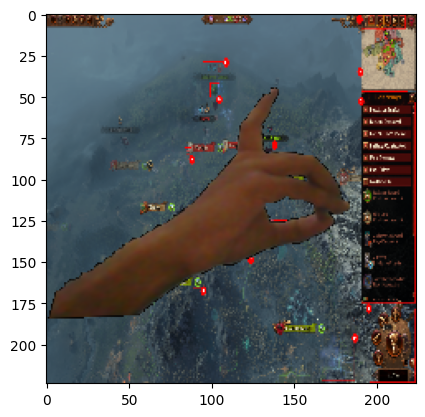

In [12]:
plt.imshow(t_bg(orig_img)[0].permute(1, 2, 0))

In [ ]:
cv.imread(bg).shape

(1200, 1920, 3)

In [1]:
%pip install fiftyone -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import fiftyone as fo
import fiftyone.zoo as foz

In [12]:
dataset = foz.load_zoo_dataset(
    "open-images-v7",
    split="train",
    label_types = ["classifications"],
    max_samples=250,
)

 100% |███████████████████| 250/250 [8.4s elapsed, 0s remaining, 42.0 files/s]      
 100% |███████████████████| 250/250 [8.6s elapsed, 0s remaining, 30.1 files/s]      
Found 100 images, downloading the remaining 150
 100% |███████████████████| 150/150 [6.2s elapsed, 0s remaining, 37.6 files/s]      
Dataset info written to 'C:\Users\kybur\fiftyone\open-images-v7\info.json'
Loading 'open-images-v7' split 'train'
 100% |█████████████████| 250/250 [2.5s elapsed, 0s remaining, 122.2 samples/s]      
Loading 'open-images-v7' split 'test'
 100% |█████████████████| 250/250 [594.2ms elapsed, 0s remaining, 420.8 samples/s]      
Loading 'open-images-v7' split 'validation'
 100% |█████████████████| 250/250 [671.8ms elapsed, 0s remaining, 372.1 samples/s]      
Dataset 'open-images-v7-250' created


In [8]:
foz.list_downloaded_zoo_datasets()

{'open-images-v7': ('C:\\Users\\kybur\\fiftyone\\open-images-v7',
  <fiftyone.zoo.datasets.ZooDatasetInfo at 0x1cdde36bbf0>)}

In [ ]:
background_paths = [sample.filepath for sample in dataset]